In [1]:
import numpy as np
from numpy import linalg
%matplotlib inline
import matplotlib.pyplot as plt
import mpl_toolkits
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as colors
import rosbag
import glob
from urdf_parser_py.urdf import URDF
from pykdl_utils.kdl_parser import kdl_tree_from_urdf_model
from pykdl_utils.kdl_kinematics import KDLKinematics
import time
from IPython import display
import random
from sklearn.neighbors import NearestNeighbors

from scipy import interpolate

In [2]:
data_path = './Robot_ViconNovember/'
folder = './Align/'
bag_idx = 1
# Load data

X_vicon = np.load(data_path+folder+'vicon_dynaPosArr%d.npy'%bag_idx)
t_vicon = np.load(data_path+folder+'viconbag_time_dyna%d.npy'%bag_idx)

theta_robot = np.load(data_path+folder+'ja_array_dyna%d.npy'%bag_idx)
t_theta = np.load(data_path+folder+'robotbag_Jointstime_dyna%d.npy'%bag_idx)

theta_turret = np.load(data_path+folder+'ja_turretCam_dyna%d.npy'%bag_idx)

X_marker = np.load(data_path+folder+'robot_dynaPosArr%d.npy'%bag_idx) 
t_marker = np.load(data_path+folder+'robotbag_Tagtime_dyna%d.npy'%bag_idx)

theta_cam = np.stack((theta_robot[:,0],theta_turret)).T


In [3]:
###ICP Transformations for each dataset
icpT0 = np.array([[ 0.98406577, -0.17605702, -0.02486944, -0.03333903],
       [ 0.17543957,  0.98416865, -0.02516012, -0.05192581],
       [ 0.02890534,  0.02039613,  0.99937404, -0.00247042],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
icpT1 = np.array([[ 0.99756793, -0.06604025, -0.02229153,  0.01657539],
       [ 0.06540669,  0.99746448, -0.02804589,  0.00221307],
       [ 0.02408717,  0.02651967,  0.99935805, -0.02207707],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
icpT2 = np.array([[ 0.99514554,  0.07030253, -0.06886884,  0.03592206],
       [-0.07141937,  0.99734968, -0.0138882 ,  0.04100649],
       [ 0.06770994,  0.01873935,  0.99752905, -0.03946576],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

icpT3 = np.array([[ 0.99795563,  0.05998181,  0.02206227, -0.02395778],
       [-0.06079507,  0.99741706,  0.03825128,  0.01230286],
       [-0.0197109 , -0.03951436,  0.99902457,  0.00191035],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
icpT4 = np.array([[ 0.98158865,  0.13226293, -0.13780505,  0.03505378],
       [-0.13742645,  0.99009864, -0.02861209,  0.05712028],
       [ 0.13265627,  0.04702337,  0.99004602, -0.06572076],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
icpT5 = np.array([[ 0.99049071,  0.11423248,  0.0766753 , -0.07531768],
       [-0.11544176,  0.99324751,  0.01151441,  0.03490833],
       [-0.07484223, -0.02025645,  0.99698963,  0.03980969],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
icpT6 = np.array([[ 0.98545898,  0.11969865,  0.12059367, -0.04643522],
       [-0.11998926,  0.99276322, -0.00487528,  0.04724059],
       [-0.12030453, -0.00966555,  0.99268998,  0.02862556],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])
icpT7 = np.array([[ 9.75727610e-01,  2.15150772e-01, -4.08139256e-02,
         1.37626506e-05],
       [-2.15115481e-01,  9.76574201e-01,  5.30649122e-03,
         6.80338139e-02],
       [ 4.09995225e-02,  3.60201724e-03,  9.99152673e-01,
        -3.05080787e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])
icpT8 = np.array([[ 0.99950484, -0.02120508, -0.02324699, -0.01791566],
       [ 0.02075214,  0.99959339, -0.01955492, -0.0023119 ],
       [ 0.0236522 ,  0.01906281,  0.99953848, -0.0082203 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [4]:
#manually aligning the vicon data to robot frame - looks ok now
def manual_alignAndICP(X,ICPTrans4m):
    # initial manual
    th = np.radians(269)
    
    t = [0.00,0.004,0.005]
    R = np.array([[np.cos(th), -np.sin(th), 0],[np.sin(th), np.cos(th), 0],[0,0,1]])
    
    X_m = np.dot(R,X.T).T - t
    
    X_m_h = np.c_[X_m, np.ones(X_m.shape[0])] 
    X_m_trans = np.dot(ICPTrans4m,X_m_h.T).T
    X_m = X_m_trans[:,:3]
    return X_m

In [5]:
# Interpolate vicon
X_v = np.zeros((t_marker.shape[0],X_vicon.shape[1]))
for j in range(X_vicon.shape[1]):
    f = interpolate.interp1d(t_vicon, X_vicon[:,j], kind='nearest',fill_value="extrapolate")
    X_v[:,j] = f(t_marker)
X_v = (manual_alignAndICP(X_v,icpT1))
    
# Interpolate theta_robot
th_r = np.zeros((t_marker.shape[0],theta_robot.shape[1]))
for j in range(theta_robot.shape[1]):
    f = interpolate.interp1d(t_theta, theta_robot[:,j], kind='nearest',fill_value="extrapolate")
    th_r[:,j] = f(t_marker)
    
# Interpolate theta_camera
th_c = np.zeros((t_marker.shape[0],theta_cam.shape[1]))
for j in range(theta_cam.shape[1]):
    f = interpolate.interp1d(t_theta, theta_cam[:,j], kind='nearest',fill_value="extrapolate")
    th_c[:,j] = f(t_marker)

In [6]:
# Create robot class for forward kinematics - speeds up, because only parses urdf once
class Robot:
    def __init__(self,model_path):
        robot = URDF.from_xml_file(model_path)
        self.kdl = KDLKinematics(robot,'base_link','marker_link')
        self.kdl_turret = KDLKinematics(robot,'base_link','turret_camera_link')
        
    def fk(self,theta):
        return self.kdl.forward(theta)
    
    #computing the transformation from the base to the turretCam_link for camera transformation relative to the ee
    def turretTransform(self,theta):
        return self.kdl_turret.forward(theta)
    

In [7]:
robot = Robot(data_path+folder+'robotMarker.urdf')

In [8]:
X_fk = (np.hstack([robot.fk(th_r[i,:])[0:3,3] for i in range(th_r.shape[0])]).T)[300:]

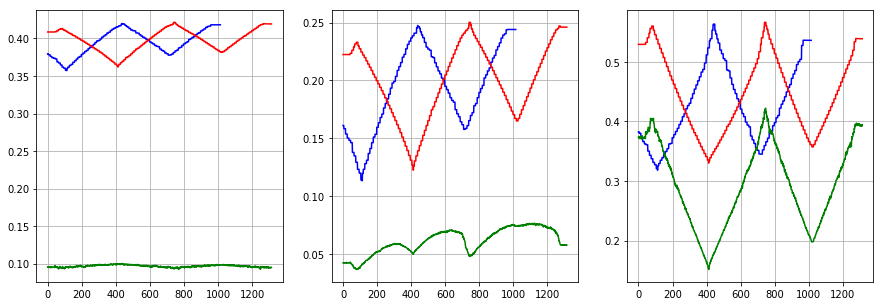

In [9]:
# Sanity check on alignment
plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(X_fk[:,i],c='b')
    plt.plot(X_v[:,i],c='r')
    plt.plot(X_marker[:,i],c='g')
    #plt.ylim(0,1)
    plt.grid()
plt.show()

In [10]:
#computing the sigma points
def sigma_points(mu,cov,n,lam):
#computes the cholesky decomposition of matrix square root A, 
#which assumes it to be a symmetric and positive definite matrix
    chol_A = np.linalg.cholesky((n+lam)*cov)
    sigma_pointx = np.zeros((7,len(mu)))
    sigma_pointx[0,:] = mu
    for i in range(3):
        #print(i)
        sigma_pointx[i+1,:] =  mu + chol_A[:,i]
    for i in range(3):
        sigma_pointx[i+4,:] =  mu - chol_A[:,i]
    return sigma_pointx

In [11]:
#assigning weights to the computed sigmas
def weight_sigma(al,n,k,b,lam):
    c = n + lam
    w_mu = np.zeros((2 * n + 1,1))
    w_mu[0,0] = lam / c
    
    w_cov = np.zeros((2 * n + 1,1))
    w_cov[0,0] = w_mu[0,0] + (1 - al**2 + b)
    for i in range(6):
        w_mu[i+1,0] = 0.5/c
        w_cov[i+1,0] = 0.5/c
    return w_mu,w_cov

In [12]:
#estimating the resulting posterior distribution of the end-effector.
def estimate_distri(transformedpoints,weight_mean,weight_cov,n,resh):
    mu_Keeprime = np.zeros((resh,1))
    cov_Keeprime = np.zeros((resh,resh))
    for i in range(2*(n) + 1):
        mu_Keeprime = mu_Keeprime + weight_mean[i]*transformedpoints[i,:].reshape(resh,1)
    for i in range(2*(n) + 1):
        cov_Keeprime = cov_Keeprime + weight_cov[i]*(transformedpoints[i,:].reshape(resh,1) 
                    - mu_Keeprime).dot((transformedpoints[i,:].reshape(resh,1) - mu_Keeprime).T)
    return mu_Keeprime, cov_Keeprime

In [13]:
#Camera model that projects a point from 3D to image plane
def rtmapping(X_world,camTransform):
    K = np.matrix([[136.848632, 0.0, 128.029255, 0],[0.0, 138.204089, 86.254287, 0],[ 0.0, 0.0, 1.0, 0.0]]) 
    P = K * camTransform 
    x_im = P.dot(np.concatenate((X_world, np.array([1])), axis=0))
    return x_im

In [14]:
#converts the point to 2d
def endEffecImage2d(ee_ImaHomo):
    for i in range(len(ee_ImaHomo )):
        x= ee_ImaHomo[:,0]/ee_ImaHomo[:,2]
        y= ee_ImaHomo[:,1]/ee_ImaHomo[:,2]
        xx,yy = x.reshape(len(ee_ImaHomo),1),y.reshape(len(ee_ImaHomo),1)
    return np.hstack((xx,yy))

In [15]:
#Unscented Transform parameters                                    
n_dim = 3
alpha = 0.5
kappa = 0
lamda = (((alpha)**2) * (n_dim + kappa) - n_dim)
beta = 2.0
resh1 = 3
resh2 = 2

m_noiseQ = 150*np.eye(2)

In [16]:
ee_mean_prior = []
ee_cov_prior = []

for t in range(th_r.shape[0]):
    
    # Define angle uncertainty
    cov_theta = np.eye(4)*0.001
    mu_theta = th_r[t,:]

    #Generate sigma joint angle points
    sigma_angles = sigma_points(mu_theta,cov_theta,n_dim,lamda)

    #Calculate sigma joint angle weights
    wsm, wsc = weight_sigma(alpha,n_dim,kappa,beta,lamda) 

    #propagating the sigma angles thru fk
    X_sigma = np.array([robot.fk(sigma_angles[i,:])[0:3,3] for i in range(sigma_angles.shape[0])])

    #Estimating the new Gaussian distribution of the end-effector space
    mu_xee, covmat_xee = estimate_distri(X_sigma,wsm, wsc,n_dim,3)

    ee_mean_prior.append(mu_xee)
    ee_cov_prior.append(covmat_xee)
    
    
    

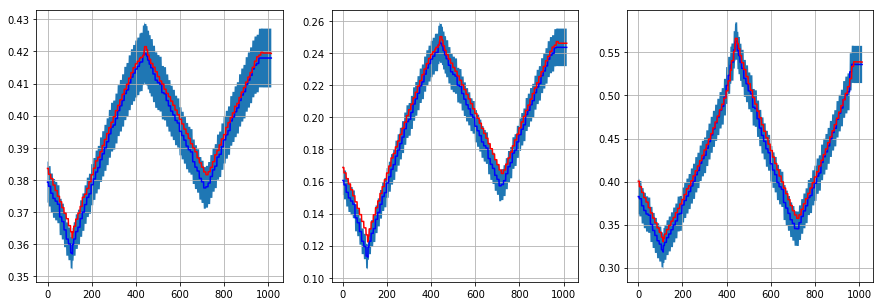

In [17]:
plt.figure(figsize=(15,5))

#1-sigma
sd = np.sqrt(np.array([np.diag(cov) for cov in ee_cov_prior[300:]]))

for i in range(3):
    plt.subplot(1,3,i+1)
    plt.plot(np.array(ee_mean_prior[300:])[:,i],c='b')
    plt.fill_between(np.arange(sd.shape[0]).ravel(),np.array(ee_mean_prior[300:])[:,i].ravel()-sd[:,i].ravel(),np.array(ee_mean_prior[300:])[:,i].ravel()+sd[:,i].ravel())
    plt.plot((X_v[:,i][300:]),c='r')
    #plt.ylim(0,1)
    plt.grid()
plt.show()

In [18]:
#plotting the end-effector distribution
def plot_ellipsoid(mu,cov,ax):
    ellipNumber = 3
    #set colour map so each ellipsoid as a unique colour
    norm = colors.Normalize(vmin=0, vmax=ellipNumber)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    #compute each and plot each ellipsoid iteratively
    for indx in range(ellipNumber):
        # your ellispsoid and center in matrix form
        A = cov
        center = mu
        # find the rotation matrix and radii of the axes
        radii, rotation = np.linalg.eig(A)
        #print(radii.shape)
        radii = np.sqrt(radii)#reduce radii by factor 0.3 
        # calculate cartesian coordinates for the ellipsoid surface
        u = np.linspace(0.0, 2.0 * np.pi, 60)
        v = np.linspace(0.0, np.pi, 60)
        x = radii[0] * np.outer(np.cos(u), np.sin(v))
        y = radii[1] * np.outer(np.sin(u), np.sin(v))
        z = radii[2] * np.outer(np.ones_like(u), np.cos(v))

        for i in range(len(x)):
            for j in range(len(x)):
                [x[i,j],y[i,j],z[i,j]] = np.dot([x[i,j],y[i,j],z[i,j]], rotation) + center

        ax.plot_surface(x, y, z,  rstride=3, cstride=3,  color='blue', linewidth=0.1, alpha=1.0, shade=True)
        ax.set_xlabel('X ', fontsize=20, fontweight='bold', color='red')
        ax.set_ylabel('Y',  fontsize=20, fontweight='bold', color='green')
        ax.set_zlabel('Z',  fontsize=20, fontweight='bold', color='blue')
#         ax.set_title('3D Manipulator of two links',fontsize = 20, fontweight = 'bold')
        plt.rcParams["font.size"] = 20
        plt.rcParams["font.weight"] = "bold"
        plt.rcParams["axes.labelweight"] = "bold"

In [19]:
#plotting the ee distribution in 2D
def plot2Dellipse(mu,cov,point,xlimit,ylimit,edgecolor,color):
    a = np.squeeze(np.asarray(point))
    x0,y0 = a
    lambda_, v = np.linalg.eig(cov)
    lambda_ = np.sqrt(lambda_)
    from matplotlib.patches import Ellipse
    import matplotlib.pyplot as plt
    ax = plt.subplot(111, aspect='equal')
    for j in range(1, 4):
        ell = Ellipse(xy=(mu[0], mu[1]),width=lambda_[0]*j*2, height=lambda_[1]*j*2,
                          angle=np.rad2deg(np.arccos(v[0, 0])),linewidth=4,edgecolor=edgecolor)
        ell.set_facecolor('none')
        ax.add_artist(ell)
    plt.scatter(x0, y0,c=color)
    #plt.scatter(x1, y1,c='blue')
    plt.xlim(xlimit)
    plt.ylim(ylimit)
    plt.xlabel('x-axis', fontsize=10)
    plt.ylabel('y-axis', fontsize=10)
    

In [20]:
ee_image_mu = []
ee_image_uncertain = []
sensor_eeIn2d = []

ee_mean_poster = []
ee_cov_poster = []

for t in range(th_r.shape[0]):
    
    camera_angle = th_c[t,:]
    marker_pos = X_marker[t,:]
    
    mu_theta = th_r[t,:]
    
    #Generate the new sigma points from the ee distribution
    sigma_xee = sigma_points(ee_mean_prior[t].ravel(), ee_cov_prior[t], n_dim, lamda)
    
    #Assign weights to the sigma points
    wsm, wsc = weight_sigma(alpha, n_dim, kappa, beta, lamda) 
    
    
    camHTH = robot.turretTransform(camera_angle)


    #Propagating sigma points through camera model
    image_eeHomog = np.ones((sigma_xee.shape[0],3))
    for i in range(sigma_xee.shape[0]):
        image_eeHomog[i,:] = rtmapping(sigma_xee[i,:] ,(np.linalg.inv(camHTH)))
        
    end_effe2D = endEffecImage2d(image_eeHomog)
    
    predictedObservat_mu,predictedUncer_cov = estimate_distri(end_effe2D,wsm, wsc,n_dim,2)
    predictedUncer_cov = predictedUncer_cov + m_noiseQ*np.eye(2)
    
    ee_image_mu.append(predictedObservat_mu)
    ee_image_uncertain.append(predictedUncer_cov)
    
    # #Propagate 3D marker measurement through camera (no rotation and translation)
    sensordata_z = rtmapping(marker_pos, np.eye(4))
    sensordata_in2d = endEffecImage2d(sensordata_z)
    sensor_eeIn2d.append(sensordata_in2d.reshape(2,1))
    
    #measuremnt noise in pixels
    
    cross_cov = np.zeros((3,2))
    for i in range(2*(3) + 1):
            cross_cov = cross_cov + wsc[i]*(sigma_xee[i,:].reshape(3,1)
                                         - ee_mean_prior[t].reshape(3,1)).dot((end_effe2D[i,:].reshape(2,1) 
                                                                  - ee_image_mu[t]).T)

    #Compute Kalman gain and the final prediction mean and covariance
    kalman_gain = cross_cov.dot(np.linalg.inv(ee_image_uncertain[t]))

    # actual_mu_meas is T to align (2,1) dim, mu_xee is reshaped from 3, to 3,1
    final_predic_mu = ee_mean_prior[t].reshape(3,1) + kalman_gain.dot(sensor_eeIn2d[t].reshape(2,1) - ee_image_mu[t])
    mu_final = np.squeeze(np.asarray(final_predic_mu))
    final_predic_cov = ee_cov_prior[t] - kalman_gain.dot(ee_image_uncertain[t]).dot(kalman_gain.T)
    ee_mean_poster.append(mu_final)
    ee_cov_poster.append(final_predic_cov)

In [21]:
marka_homog = np.hstack((X_marker,np.ones([X_marker.shape[0],1], X_marker.dtype)))
marka_inBase_list = []
for t in range(th_r.shape[0]):
    camera_angle = th_c[t,:]
    marker_pos = np.array(marka_homog)[t,:]
    camHTH = robot.turretTransform(camera_angle)
    v = marker_pos.dot((np.linalg.inv(camHTH)))
    marka_inBase_list.append((np.asarray(v[:,:3]).T))

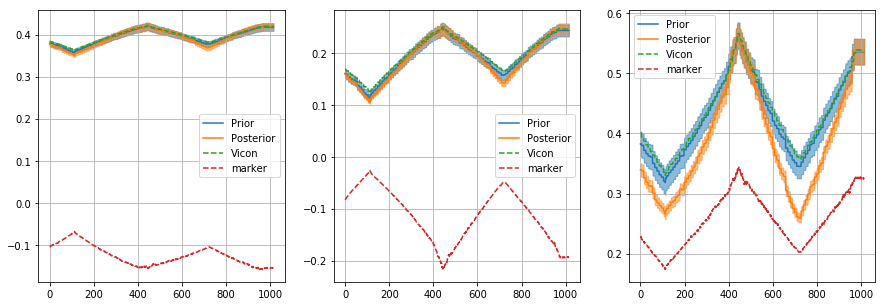

In [22]:
plt.figure(figsize=(15,5))

#1-sigma
sd = np.sqrt(np.array([np.diag(cov) for cov in ee_cov_prior[300:]]))
sd_post = np.sqrt(np.array([np.diag(cov) for cov in ee_cov_poster[300:]]))
marka_inBase_list2 = np.asarray(marka_inBase_list)
for i in range(3):
    plt.subplot(1,3,i+1)
    #####plot the mean prior and its error
    plt.plot(np.array(ee_mean_prior[300:])[:,i],'C0',label='Prior')
    plt.fill_between(np.arange(sd.shape[0]).ravel(),np.array(ee_mean_prior[300:])[:,i].ravel()-sd[:,i].ravel(),np.array(ee_mean_prior[300:])[:,i].ravel()+sd[:,i].ravel(),color='C0',alpha=0.5)
    
    #####plot the mean posterior and its error
    plt.plot(np.array(ee_mean_poster[300:])[:,i],'C1',label='Posterior')
    plt.fill_between(np.arange(sd_post.shape[0]).ravel(),np.array(ee_mean_poster[300:])[:,i].ravel()-sd_post[:,i].ravel(),np.array(ee_mean_poster[300:])[:,i].ravel()+sd_post[:,i].ravel(),color='C1',alpha=0.5)
    
    ####plot vicon
    plt.plot(X_v[:,i][300:],'--',color='C2',label='Vicon')
    
    #####plot the 3Dmarker position in the base frame
    plt.plot(marka_inBase_list2[300:][:,i],'--',color='C3',label='marker')
    
    #plt.ylim(0,1)
    plt.grid()
    
    plt.legend()
plt.show()